In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cp -r /content/drive/MyDrive/ML_Final_Project/midi_np_translation .
! cp -r /content/drive/MyDrive/ML_Final_Project/preprocessed_dataset .
! cp -r /content/drive/MyDrive/ML_Final_Project/input_midi .

In [3]:
! unzip /content/preprocessed_dataset/irealpro_midi.zip
! unzip /content/input_midi/irealpro_transposed.zip
! pip install pretty_midi

串流輸出內容已截斷至最後 5000 行。
  inflating: irealpro_midi/Four In One_d2.mid.npy  
  inflating: irealpro_midi/Fly Me To The Moon_o0.mid.ans.npy  
  inflating: irealpro_midi/Heyoke_p6.mid.npy  
  inflating: irealpro_midi/Ecaroh_p2.mid.npy  
  inflating: irealpro_midi/52nd Street Theme_p4.mid.ans.npy  
  inflating: irealpro_midi/All Of You_o0.mid.ans.npy  
  inflating: irealpro_midi/A Kiss To Build A Dream On_d1.mid.ans.npy  
  inflating: irealpro_midi/Freckle Face_p5.mid.npy  
  inflating: irealpro_midi/Day In, Day Out_d2.mid.ans.npy  
  inflating: irealpro_midi/Evidence_p1.mid.ans.npy  
  inflating: irealpro_midi/Copenhagen_d5.mid.ans.npy  
  inflating: irealpro_midi/Heart And Soul_p1.mid.npy  
  inflating: irealpro_midi/I May Be Wrong_d3.mid.npy  
  inflating: irealpro_midi/I'm Old Fashioned_p6.mid.ans.npy  
  inflating: irealpro_midi/I Found A New Baby_d2.mid.npy  
  inflating: irealpro_midi/As Long As I Live_d3.mid.npy  
  inflating: irealpro_midi/Good Bait_p6.mid.npy  
  inflating: irealpro_

In [1]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Masking, Bidirectional, LSTM, TimeDistributed, Dense, Activation

In [3]:
BATCH_SIZE = 256
VALIDATION_RATIO = 0.1

PIECE_LEN = 1024
n_feature = 42
n_hidden = 200
n_pitch = 52
learning_rate = 0.001

## build dataset

In [4]:
def load_npy_data(x_path, y_path, offset):
    x = np.load(x_path)
    y = np.load(y_path)
    if x.shape[0] >= offset+PIECE_LEN:
        return x[offset:offset+PIECE_LEN].astype(np.float64), y[offset:offset+PIECE_LEN].astype(np.float64)
    else:
        pad_count = offset + PIECE_LEN - x.shape[0]
        x = np.pad(x[offset:], ((0, pad_count), (0, 0)), 'constant', constant_values=-1).astype(np.float64)
        y = np.pad(y[offset:], ((0, pad_count), (0, 0)), 'constant', constant_values=-1).astype(np.float64)
        return x, y

def generate_dataset(input_dir: str):
    x_paths = []
    y_paths = []
    offsets = []
    for file_name in sorted(os.listdir(input_dir)):
        if file_name.endswith(".ans.npy"):
            y_path = str(os.path.join(input_dir, file_name))
            x_path = str(os.path.join(input_dir, file_name.replace(".ans.npy", ".npy")))
            assert os.path.exists(x_path), f"corresponding input file {x_path} doesn't exist"
            y_content = np.load(y_path)
            for offset in range(0, y_content.shape[0], PIECE_LEN):
                y_paths.append(y_path)
                x_paths.append(x_path)
                offsets.append(offset)

    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_paths, y_paths, offsets)).shuffle(100000)
    train_dataset = train_dataset.map(lambda x_path, y_path, offset: tf.numpy_function(load_npy_data, [x_path, y_path, offset], [tf.float64, tf.float64]))
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(-1).cache()
    
    return train_dataset

In [ ]:
train_dataset = generate_dataset("/content/irealpro_midi")

## build model

In [5]:
# print("Creating model")
input = tf.keras.Input(shape=(PIECE_LEN, n_feature))  
x = Masking(mask_value=-1, input_shape=(PIECE_LEN, n_feature))(input) # Ignore Padded Data
x = Bidirectional(LSTM(units=n_hidden, input_shape=(1, n_feature), return_sequences=True))(x)
x = TimeDistributed(Dense(n_pitch, activation="softmax"))(x)
model = tf.keras.Model(inputs=input, outputs=x)

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                 metrics=tf.keras.metrics.CategoricalAccuracy())
print(model.summary())

optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 42)]        0         
                                                                 
 masking (Masking)           (None, 1024, 42)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1024, 400)        388800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 1024, 52)         20852     
 ibuted)                                                         
                                                                 
Total params: 409,652
Trainable params: 409,652
Non-trainable params: 0
_________________________________________________________________
None


## loss/accuracy function

In [6]:
def masked_loss_function(y_true, y_pred):
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=2), -1*n_pitch)
    loss = tf.losses.categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(mask, loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_accuracy(y_true, y_pred):
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=2), -1*n_pitch)
    acc = tf.metrics.categorical_accuracy(y_true, y_pred)
    mask = tf.cast(mask, acc.dtype)
    acc *= mask
    return tf.reduce_mean(acc)

### restore checkpoint

In [9]:
! cp -r /content/drive/MyDrive/ML_Final_Project/saved_model/checkpoints_1024 .
! mv checkpoints_1024 checkpoints

In [ ]:
checkpoint_dir = './checkpoints/Bidirectional_LSTM'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

In [ ]:
checkpoint.restore(checkpoint_prefix+"-2")

## training

In [7]:
@tf.function
def train_step(x, y):
    loss = 0
    with tf.GradientTape() as tape:
        pred = model(x)
        
        loss = masked_loss_function(y, pred)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = masked_accuracy(y, pred)

    return loss, acc

In [ ]:
# set the epochs for training
EPOCHS = 200
loss_history = []

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    total_loss = 0
    total_acc = 0
    steps_per_epoch = 0

    for x, y in train_dataset:
        batch_loss, batch_acc = train_step(x, y)
        total_loss += batch_loss
        total_acc += batch_acc
        steps_per_epoch += 1
    
    # saving (checkpoint) the model every 2 epochs
    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f} Acc {total_acc / steps_per_epoch:.4f}')
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    loss_history.append(total_loss / steps_per_epoch)

Epoch 1 Loss 0.2623 Acc 0.6662
Time taken for 1 epoch 54.379414558410645 sec

Epoch 2 Loss 0.2496 Acc 0.6715
Time taken for 1 epoch 10.298807382583618 sec

Epoch 3 Loss 0.2467 Acc 0.6728
Time taken for 1 epoch 9.976363182067871 sec

Epoch 4 Loss 0.2457 Acc 0.6733
Time taken for 1 epoch 9.762989282608032 sec

Epoch 5 Loss 0.2446 Acc 0.6738
Time taken for 1 epoch 10.094513893127441 sec

Epoch 6 Loss 0.2445 Acc 0.6738
Time taken for 1 epoch 9.88956880569458 sec

Epoch 7 Loss 0.2440 Acc 0.6740
Time taken for 1 epoch 9.684703826904297 sec

Epoch 8 Loss 0.2463 Acc 0.6729
Time taken for 1 epoch 10.225905895233154 sec

Epoch 9 Loss 0.2473 Acc 0.6723
Time taken for 1 epoch 9.563478946685791 sec

Epoch 10 Loss 0.2478 Acc 0.6722
Time taken for 1 epoch 9.561127662658691 sec

Epoch 11 Loss 0.2476 Acc 0.6723
Time taken for 1 epoch 9.625629901885986 sec

Epoch 12 Loss 0.2445 Acc 0.6737
Time taken for 1 epoch 9.844700813293457 sec

Epoch 13 Loss 0.2438 Acc 0.6740
Time taken for 1 epoch 9.8940956592559

KeyboardInterrupt: ignored

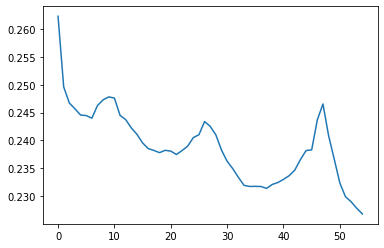

In [ ]:
plt.plot(loss_history)

In [ ]:
checkpoint.save(checkpoint_prefix)

'./checkpoints/Bidirectional_LSTM/ckpt-2'

## predict

In [9]:
def slice_per_step(a, step=PIECE_LEN):
    # add -1 to the end of each sample to make them the same length per step(piece_length)
    pad_count = step - (a.shape[0] % step)
    # print(a.shape, end=' ')
    if pad_count!=step : 
        # print('pad by',pad_count, end=' ')
        a = np.pad(a, ((0, pad_count), (0, 0)), 'constant', constant_values=-1)
    # reshape into per step
    a = np.reshape(a, (-1, step, a.shape[1]))
    # print('to',a.shape)
    return a

In [8]:
import midi_np_translation.output2midi as output2midi

In [ ]:
PATH = "test_input"
# load np file
test_file = np.load("irealpro_midi/Autumn Leaves_o0.mid.npy")
# test_file_truth = np.load(PATH + "/" + "4on6.mid.ans.npy")
# output2midi.output_to_midi(bass_ndarr=test_file_truth, output_path="4on6_truth.mid")
test_result = model.predict(slice_per_step(test_file))
# test_result = np.argmax(test_result, axis=2)
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), ref_midi_path="irealpro_transposed/Autumn Leaves_o0.mid", output_path="yo_al.mid")

1/1 [==============================] - 2s 2s/step


In [ ]:
PATH = "test_input"
# load np file
test_file = np.load("irealpro_midi/Fly Me To The Moon_o0.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), ref_midi_path="irealpro_transposed/Fly Me To The Moon_o0.mid", output_path="moon.mid")

1/1 [==============================] - 0s 81ms/step


## phase 2

In [ ]:
! unzip /content/preprocessed_dataset/dense_jazz.zip
! unzip input_midi/transpose_augmentation.zip

In [17]:
train_dataset = generate_dataset("/content/dense_jazz/")

In [15]:
checkpoint_dir = './checkpoints/Bidirectional_LSTM_Real'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

In [14]:
! cp -r "/content/drive/MyDrive/ML_Final_Project/saved_model/checkpoints_1230-1812" .
! mv "checkpoints_1230-1812" "checkpoints"

In [16]:
checkpoint.restore(checkpoint_prefix+"-1")

In [20]:
# set the epochs for training
EPOCHS = 200
loss_history = []

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    total_loss = 0
    total_acc = 0
    steps_per_epoch = 0

    for x, y in train_dataset:
        batch_loss, batch_acc = train_step(x, y)
        total_loss += batch_loss
        total_acc += batch_acc
        steps_per_epoch += 1
    
    # saving (checkpoint) the model every 2 epochs
    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f} Acc {total_acc / steps_per_epoch:.4f}')
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    loss_history.append(total_loss / steps_per_epoch)

Epoch 1 Loss 1.0775 Acc 0.4268
Time taken for 1 epoch 15.457767724990845 sec

Epoch 2 Loss 1.0717 Acc 0.4289
Time taken for 1 epoch 15.259926557540894 sec

Epoch 3 Loss 1.0725 Acc 0.4285
Time taken for 1 epoch 14.995627641677856 sec

Epoch 4 Loss 1.0789 Acc 0.4260
Time taken for 1 epoch 14.830582618713379 sec

Epoch 5 Loss 1.0815 Acc 0.4252
Time taken for 1 epoch 14.828281879425049 sec

Epoch 6 Loss 1.0723 Acc 0.4290
Time taken for 1 epoch 14.908663272857666 sec

Epoch 7 Loss 1.0582 Acc 0.4339
Time taken for 1 epoch 14.986649990081787 sec

Epoch 8 Loss 1.0515 Acc 0.4364
Time taken for 1 epoch 15.08856987953186 sec

Epoch 9 Loss 1.0359 Acc 0.4420
Time taken for 1 epoch 14.98063063621521 sec

Epoch 10 Loss 1.0271 Acc 0.4452
Time taken for 1 epoch 14.909509181976318 sec

Epoch 11 Loss 1.0214 Acc 0.4473
Time taken for 1 epoch 14.924076318740845 sec

Epoch 12 Loss 1.0182 Acc 0.4484
Time taken for 1 epoch 14.915481328964233 sec

Epoch 13 Loss 1.0160 Acc 0.4491
Time taken for 1 epoch 14.95135

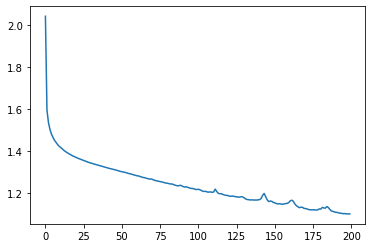

In [ ]:
plt.plot(loss_history)

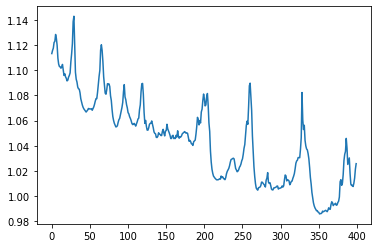

In [21]:
plt.plot(loss_history)

In [ ]:
test_file = np.load("irealpro_midi/Autumn Leaves_o0.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), ref_midi_path="irealpro_transposed/Autumn Leaves_o0.mid", output_path="yo_al.mid")

1/1 [==============================] - 0s 117ms/step


In [ ]:
test_file = np.load("/content/dense_jazz/AutumnLeaves_o0.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), ref_midi_path="/content/transpose_augmentation/AutumnLeaves_o0.mid", output_path="autumn_real.mid")

1/1 [==============================] - 0s 86ms/step


In [ ]:
test_file = np.load("/content/dense_jazz/PieceOfMyWish_p1.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), ref_midi_path="/content/transpose_augmentation/PieceOfMyWish_p1.mid", output_path="pow.mid")

1/1 [==============================] - 0s 62ms/step


In [ ]:
test_file = np.load("/content/55Dive_o0.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), ref_midi_path="/content/55Dive_o0.mid", output_path="55d.mid")

1/1 [==============================] - 0s 56ms/step


In [ ]:
checkpoint.save(checkpoint_prefix)

'./checkpoints/Bidirectional_LSTM_Real/ckpt-1'

In [ ]:
! cp -r "/content/checkpoints" "/content/drive/MyDrive/ML_Final_Project/saved_model"